In [1]:
import cv2
import os
import time
import numpy as np
import h5py
import os, random
import matplotlib.pylab as plt
import keras.utils.vis_utils as vutil
from skimage.transform import resize
from IPython.display import SVG
import tensorflow as tf
import keras.models as models
from keras.optimizers import SGD, Adam, RMSprop
from imgaug import augmenters as iaa
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import MaxPooling2D, UpSampling2D, Conv2D, Conv2DTranspose, ZeroPadding2D, Conv3D, MaxPooling3D, ZeroPadding3D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Lambda, add, LSTM, TimeDistributed, concatenate
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.utils import conv_utils
from keras.engine.topology import Layer
from keras.engine import InputSpec
import numpy as np
from keras.layers import LSTM
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input
import matplotlib.animation as animation
import sys

%matplotlib inline

Using TensorFlow backend.


In [2]:
def show(image, cmap='gray', ax=None):
    if ax is None:
        plt.figure()
    
    plt.imshow(image[:,:,::-1].astype('uint8'), cmap=cmap)

In [3]:
FRAME_H, FRAME_W = 112, 112
TIMESTEPS = 16

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Code up the generators

A short snippet to create training set and validation set from the given video data.

In [15]:
"""video_file = 'train'

video_inp = 'data/' + video_file + '.mp4'
label_inp = open('data/' + video_file + '.txt').readlines()

video_reader = cv2.VideoCapture(video_inp)
train_image = 'data/' + video_file + '/images/'
train_label = open('data/' + video_file + '/labels.txt', 'w')

counter = 0

while(True):
    ret, frame = video_reader.read()

    if ret == True:
        cv2.imwrite(train_image + str(counter).zfill(6) + '.png', frame)
        train_label.write(label_inp[counter])
        counter += 1
    else:
        break

video_reader.release()
train_label.close()"""

These are a set of functions to add disturtances to the images used during the training process.

In [4]:
sometime = lambda aug: iaa.Sometimes(0.3, aug)
sequence = iaa.Sequential([ #sometime(iaa.GaussianBlur((0, 1.5))), # blur images with a sigma between 0 and 3.0
                            #sometime(iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))), # sharpen images
                            #sometime(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 3.), per_channel=0.5)), # add gaussian noise to images
                            sometime(iaa.Dropout((0.0, 0.1))), # randomly remove up to 10% of the pixels
                            sometime(iaa.CoarseDropout((0.0, 0.1), size_percent=(0.01, 0.02), per_channel=0.2)),
                            #sometime(iaa.Add((-10, 10), per_channel=0.5)), # change brightness of images (by -10 to 10 of original value)
                          ],
                          random_order=True # do all of the above in random order
                         )

def normalize(image):
    return image - [104.00699, 116.66877, 122.67892]

def augment(image, flip, bright_factor):
    # random disturbances borrowed from IAA
    image = sequence.augment_image(image)
    
    # random brightness change
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    
    # random flip (vertical axis)
    if flip:
        image = cv2.flip(image, 1)
                
    return image

This is the class to generate batches for both training and validation.

In [5]:
class BatchGenerator:
    def __init__(self, file_path, indices, batch_size, timesteps=1, shuffle=True, jitter = True, norm=True, overlap=False):
        self.file_path  = file_path
        self.batch_size = batch_size
        self.timesteps  = timesteps
        
        self.shuffle = shuffle
        self.jitter  = jitter
        self.norm    = norm

        self.images = sorted(os.listdir(self.file_path + 'images/'))
        self.labels = open(self.file_path + 'labels.txt').readlines()
        
        self.indices = indices

    def get_gen(self):
        num_img = len(self.indices)
        
        l_bound = 0
        r_bound = self.batch_size if self.batch_size < num_img else num_img    
        
        if self.shuffle: np.random.shuffle(self.indices)

        while True:
            if l_bound == r_bound:
                l_bound = 0
                r_bound = self.batch_size if self.batch_size < num_img else num_img
                
                if self.shuffle: np.random.shuffle(self.indices)

            # the arrays which hold in the inputs and outputs
            x_batch = np.zeros((r_bound - l_bound, self.timesteps, FRAME_H, FRAME_W, 3))
            y_batch = np.zeros((r_bound - l_bound, 1))
            currt_inst = 0        

            for index in self.indices[l_bound:r_bound]:
                #if index > 2*self.timesteps:
                #    index -= np.random.randint(0, self.timesteps)
                
                # construct each input
                flip = (np.random.random() > 0.5)
                bright_factor = 0.5 + np.random.uniform() * 0.5
                
                for i in xrange(self.timesteps):
                    image = cv2.imread(self.file_path + 'images/' + self.images[index-self.timesteps+1+i])
                    heigh = image.shape[0]
                    image = image[np.concatenate([np.arange(heigh/3), np.arange(heigh*2/3,heigh)]),:,:]
                    image = cv2.resize(image.copy(), (FRAME_H, FRAME_W))
                    
                    if self.jitter: image = augment(image, flip, bright_factor)
                    if self.norm:   image = normalize(image)                    
                    
                    x_batch[currt_inst, i] = image

                # construct each output
                speeds = [float(speed) for speed in self.labels[index-self.timesteps+1:index+1]]
                y_batch[currt_inst] = np.mean(speeds)

                currt_inst += 1
                
            yield x_batch, y_batch

            l_bound = r_bound
            r_bound = r_bound + self.batch_size
            if r_bound > num_img: r_bound = num_img
                
    def get_size(self):
        return len(self.indices)/self.batch_size 

Perform some visualization to make sure that the generated batches make sense.

In [53]:
data_folder = 'data/train/'

indices = range(TIMESTEPS-1, len(os.listdir(data_folder + 'images/')), TIMESTEPS)
gen_train = BatchGenerator(data_folder, indices, batch_size=4, timesteps=TIMESTEPS)
generator = gen_train.get_gen()

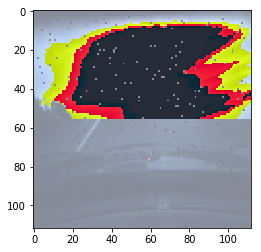

In [56]:
show(generator.next()[0][0][0])

# Construct the model

In [6]:
model = Sequential()
input_shape=(TIMESTEPS, FRAME_H, FRAME_W, 3) # l, h, w, c

# 1st layer group
model.add(Conv3D(64, (3, 3, 3),  activation='relu', padding='same', name='conv1', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='valid', name='pool1'))

# 2nd layer group
model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same', name='conv2'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool2'))

# 3rd layer group
model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv3a'))
model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv3b'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool3'))

# 4th layer group
model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv4a'))
model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv4b'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool4'))

# 5th layer group
model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv5a'))
model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv5b'))
model.add(ZeroPadding3D(padding=((0, 0), (0, 1), (0, 1)), name='zeropad5'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool5'))
model.add(Flatten())

# FC layers group
model.add(Dense(4096, activation='relu', name='fc6'))
model.add(Dropout(.5))
model.add(Dense(4096, activation='relu', name='fc7'))
model.add(Dropout(.5))
model.add(Dense(1,    activation='linear', name='fc8'))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 16, 112, 112, 64)  5248      
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 16, 56, 56, 64)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 16, 56, 56, 128)   221312    
_________________________________________________________________
pool2 (MaxPooling3D)         (None, 8, 28, 28, 128)    0         
_________________________________________________________________
conv3a (Conv3D)              (None, 8, 28, 28, 256)    884992    
_________________________________________________________________
conv3b (Conv3D)              (None, 8, 28, 28, 256)    1769728   
_________________________________________________________________
pool3 (MaxPooling3D)         (None, 4, 14, 14, 256)    0         
__________

# Load weights pretrained on the Sports-1M dataset

In [8]:
sports_1m = h5py.File('c3d-sports1M_weights.h5', mode='r')

for i in xrange(len(model.layers)):
    layer = model.layers[i]
    layer_name = 'layer_' + str(i)
    
    weights = sports_1m[layer_name].values()
    weights = [weight.value for weight in weights]
    weights = [weight if len(weight.shape) < 4 else weight.transpose(2,3,4,1,0) for weight in weights]
    
    layer.set_weights(weights)
    
    # ignore the last 2 layer, 1 dropout and 1 dense
    if i > len(model.layers) - 3:
        break

# Train the network

In [9]:
early_stop  = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, mode='min', verbose=1)
checkpoint  = ModelCheckpoint('weight_c3d.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)

data_folder = 'data/train/'
split_ratio = 0.90

indices = range(TIMESTEPS-1, len(os.listdir(data_folder + 'images/')), TIMESTEPS)
np.random.shuffle(indices)

train_indices = list(indices[0:int(len(indices)*split_ratio)])
valid_indices = list(indices[int(len(indices)*split_ratio):])

gen_train = BatchGenerator(data_folder, train_indices, batch_size=4, timesteps=TIMESTEPS)
gen_valid = BatchGenerator(data_folder, valid_indices, batch_size=4, timesteps=TIMESTEPS, jitter = False)

In [10]:
def custom_loss(y_true, y_pred):
    loss = tf.squared_difference(y_true, y_pred)
    loss = tf.reduce_mean(loss)
    
    return loss

In [83]:
model.load_weights('weight_c3d.h5')

In [14]:
tb_counter  = max([int(num) for num in os.listdir('../logs/speed/')] or [0]) + 1
tensorboard = TensorBoard(log_dir='../logs/speed/' + str(tb_counter), histogram_freq=0, write_graph=True, write_images=False)

sgd = SGD(lr=1e-5, decay=0.0005, momentum=0.9)
model.compile(loss=custom_loss, optimizer=sgd)

#adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#model.compile(loss=custom_loss, optimizer=adam)

#rms = RMSprop(lr=1e-3, rho=0.9, epsilon=1e-08, decay=0.0)
#model.compile(loss=custom_loss, optimizer=rms)

model.fit_generator(generator = gen_train.get_gen(),
                    steps_per_epoch = gen_train.get_size(), 
                    epochs  = 5, 
                    verbose = 1,
                    validation_data = gen_valid.get_gen(), 
                    validation_steps = gen_valid.get_size(), 
                    callbacks = [early_stop, checkpoint, tensorboard], 
                    max_q_size = 8)

Epoch 1/5
302/302 [==============================] - 358s - loss: 4.6813 - val_loss: 5.2479
Epoch 2/5
302/302 [==============================] - 357s - loss: 3.6875 - val_loss: 4.3777
Epoch 3/5
302/302 [==============================] - 361s - loss: 2.7981 - val_loss: 3.1666
Epoch 4/5
302/302 [==============================] - 357s - loss: 2.9679 - val_loss: 4.0543
Epoch 5/5
302/302 [==============================] - 361s - loss: 2.1989 - val_loss: 3.1584


# Analyze the trained network

In [16]:
file_name = 'udacity' # name without extension of arbitrary dashcam video

video_inp = 'data/' + file_name + '.mp4'
video_out = 'data/' + file_name + '_out.mp4'
label_inp = open('data/' + file_name + '.txt', 'r').readlines() if os.path.exists('data/' + file_name + '.txt') else None
label_out = open('data/' + file_name + '_pred.txt', 'w')

video_reader = cv2.VideoCapture(video_inp)
h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_writer = cv2.VideoWriter(video_out, fourcc, 20.0, (w, h))

x_batch_original = np.zeros((TIMESTEPS, h, w, 3))
x_batch = np.zeros((1, TIMESTEPS, FRAME_H, FRAME_W, 3))
frame_counter = 0
frame_counter_all = 0
curr_speed = 0.
acc_error = 0

while(True):
    ret, image = video_reader.read()

    if ret == True:
        if frame_counter_all > -1: # only start processing from certain frame count
            x_batch_original[frame_counter] = image

            heigh = image.shape[0]
            image = image[np.concatenate([np.arange(heigh/3), np.arange(heigh*2/3,heigh)]),:,:]
            image = cv2.resize(image.copy(), (FRAME_H, FRAME_W))
            image = normalize(image)

            x_batch[0, frame_counter] = image

            if frame_counter == TIMESTEPS - 1:
                curr_speed = model.predict(x_batch)[0][0]
                frame_counter = -1

                for i in xrange(TIMESTEPS):
                    image = x_batch_original[i]
                    caption = 'Speed (Predicted): ' + str("{0:.2f}".format(curr_speed))
                    image = cv2.putText(image, caption, (5,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 3)

                    # write true speed if available
                    if label_inp is not None:
                        true_speed = float(label_inp[frame_counter_all-(TIMESTEPS-1)+i].strip())
                        caption = 'Speed (Actual): ' + str("{0:.2f}".format(true_speed))
                        image = cv2.putText(image, caption, (5,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 3)
                        
                        acc_error += (curr_speed - true_speed) ** 2
                        caption = 'MSE: ' + str("{0:.2f}".format(acc_error/(frame_counter_all-TIMESTEPS+1+i+1)))
                        image = cv2.putText(image, caption, (5,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 3)                        

                    video_writer.write(np.uint8(image))
                    label_out.write(str(curr_speed) + '\n')

            frame_counter += 1
    else:
        break
    
    frame_counter_all += 1

video_reader.release()
video_writer.release()

label_out.close()

# Test code

In [58]:
video_out = 'data/udacity.mp4'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_writer = cv2.VideoWriter(video_out, fourcc, 20.0, (640, 480))

labels = open('data/udacity.txt', 'w')

with open('data/output/interpolated.csv', 'r') as csvfile:
    print csvfile.readline()
    
    for row in csvfile:
        if 'center' in row:
            row = row.split(',')

            image = cv2.imread('data/output/' + row[5])
            
            video_writer.write(np.uint8(image))
            #labels.write(row[8] + '\n')
            labels.write(str(float(row[8])*0.621371) + '\n')
            
video_writer.release()
labels.close()

index,timestamp,width,height,frame_id,filename,angle,torque,speed,lat,long,alt



In [80]:
indices = range(16, len(os.listdir('data/udacity/images/')), 16)
np.random.shuffle(indices)

train_indices = indices[0:int(len(indices)*0.8)]
valid_indices = indices[int(len(indices)*0.8):]